In [1]:
import numpy as np
import autograd.numpy as autonp
from autograd import grad, jacobian
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from src.sqr_gaussian_inference import * 
from src.gaussian_inference import *
from src.ODE_filters import *
from src.helpers import future_prediction
from src.plotting_utils import *
from tqdm import tqdm

### Plotting Specifications

In [2]:
from tueplots import axes
plt.rcParams.update(axes.lines())
plt.rcParams.update({"figure.dpi": 600})

In [3]:
plt.rcParams['figure.figsize']

[6.4, 4.8]

In [4]:
from tueplots import figsizes
figsize_config = figsizes.neurips2021(nrows=1, ncols=1)
##figsize_config['figure.figsize'][1] = 0.5
plt.rcParams.update(figsize_config)

In [5]:
plt.rcParams['figure.figsize']

[5.5, 3.399186938124422]

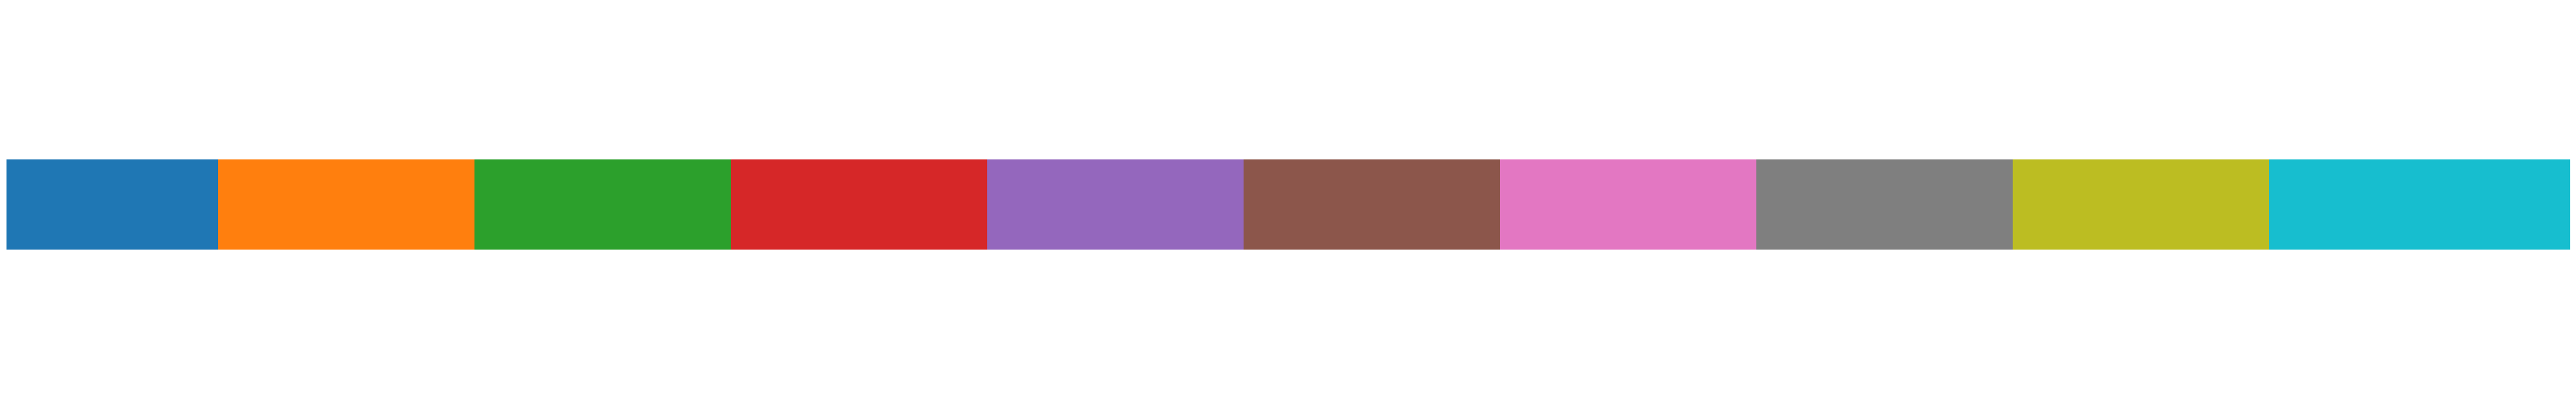

In [6]:
from cycler import cycler

# Get the color cycle from rcParams
color_cycler = plt.rcParams['axes.prop_cycle']
colors = color_cycler.by_key()['color']

# Visualize the colors
fig, ax = plt.subplots(figsize=(6, 1))
for i, color in enumerate(colors):
    ax.plot([i, i+1], [1, 1], color=color, linewidth=15)
ax.set_xlim(0, len(colors))
ax.set_ylim(0.5, 1.5)
ax.axis('off')
plt.show()

### ODE Problem Setup

In [7]:
#ODE - IVP:
vf = lambda x: np.array([
    2*x[0]/3 - 4*x[0]*x[1]/3,
    x[0]*x[1] - x[1]
])
y0 = np.array([1,1])

d = 2
q = 2

#exact solution:
#x_exact = lambda t: 1 / (1 + (1 / 0.01 - 1) * np.exp(-t))
#x_prime_exact = lambda t: (1 / 0.01 - 1) * np.exp(-t) / (1 + (1 / 0.01 - 1) * np.exp(-t))**2
#x_prime_prime_exact = lambda t: x_exact(t)*(1-x_exact(t))*(1-2*x_exact(t))
#exact_sols = [x_exact, x_prime_exact, x_prime_prime_exact]

#Prior
A = lambda h: np.array([[1, h, h**2/2], [0, 1, h], [0, 0, 1]])
sigma = 1.0
Q = lambda h: sigma**2 * np.array([[h**5/20, h**4/8, h**3/6], [h**4/8, h**3/3, h**2/2], [h**3/6, h**2/2, h]])
X_0 = np.array([y0, vf(y0), (1-y0)*(1-2*y0)*y0])
mu_0 = np.concat([y0, vf(y0), np.zeros(d)])
Sigma_0 = np.eye(d*(q+1))*0.

#Discretization
t0, t1 = 0.0, 30.0
N = 60
ts = np.linspace(t0, t1, num=N+1, endpoint=True)
h = (t1 - t0) / N


#Consequences of constant step size
A_h = np.kron(A(h), np.eye(d))
Q_h = np.kron(Q(h), np.eye(d))
b_h = np.zeros((q+1)*d)
R_h = np.eye(d)*0.

E_0 = autonp.array([1,0,0])
E_1 = autonp.array([0,1,0])
E_0 = autonp.kron(E_0, np.eye(d))
E_1 = autonp.kron(E_1, np.eye(d))

#Measurement operator
g = lambda X: E_1 @ X - vf(E_0@X)
jacobian_g = jacobian(g)

#Data
z_sequence = np.zeros((N,d))

### Compute and Plot filtering results

In [8]:
m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

In [9]:
m_sequence = np.asarray(m_sequence, dtype=float)
P_sequence = np.asarray(P_sequence, dtype=float)
m_predictions = np.asarray(m_predictions, dtype=float)
P_predictions = np.asarray(P_predictions, dtype=float)

In [10]:
m_smoothed, P_smoothed = compute_kalman_backward(m_sequence, P_sequence, m_predictions, P_predictions, A_h, N)

In [11]:
N_exact = 1000
h_exact = (t1-t0)/N_exact
t = np.linspace(t0,t1, N_exact+1)
z_sequence2 = np.zeros((N_exact,d))
A_h2 = np.kron(A(h_exact), np.eye(d))
Q_h2 = np.kron(Q(h_exact), np.eye(d))
m_sequence2, P_sequence2, m_predictions2, P_predictions2 = compute_kalman_forward(mu_0, Sigma_0, A_h2, b_h, Q_h2, R_h, g, jacobian_g, z_sequence2, N_exact)
m_sequence2 = np.asarray(m_sequence2, dtype=float)
P_sequence2 = np.asarray(P_sequence2, dtype=float)
m_predictions2 = np.asarray(m_predictions2, dtype=float)
P_predictions2 = np.asarray(P_predictions2, dtype=float)
#Consequences of constant step size

m_exact, _ = compute_kalman_backward(m_sequence2, P_sequence2, m_predictions2, P_predictions2, A_h2, N_exact)

### Plotting Helpers

In [12]:
def plot_ax(ts, m, P, t, x_exact, x_lim=None, y_lim=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(t, x_exact(t), linestyle='--', color="black", label="ground truth")
    ax.plot(ts, m, color=colors[0], marker='.', label="filtered estimate")
    #ax.scatter(ts, m, color=colors[0], label="filtered estimate")
    
    P_f_safe = np.maximum(P, 0)
    margin = 2*np.sqrt(P_f_safe)
    ax.fill_between(ts, m - margin, m + margin, alpha=0.2, color=colors[0], label=r'$\pm 1\sigma$')
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        ax.set_yticks(y_lim)
    
    return ax

In [13]:
def plot_ax_with_pred(ts, m, P, t, x_exact, m_future, P_future, k, x_lim=None, y_lim=None, ax=None, c='blue'):
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(t, x_exact, linestyle='--', color="black", label="ground truth")
    ax.plot(ts[:k], m[:k], color=c, label="filtered estimate",zorder=8)
    ax.plot(ts[k-1:], m_future, color='black', label="future prediction", alpha=0.5, linestyle=':')
    #ax.scatter(ts, m, color=colors[0], label="filtered estimate")
    
    P_f_safe = np.maximum(P, 1e-4)
    P_future = np.maximum(P_future, 1e-4)
    margin = 2*np.sqrt(P_f_safe)
    margin_future = 2*np.sqrt(P_future)
    ax.fill_between(ts[:k], m[:k] - margin[:k], m[:k] + margin[:k], alpha=0.2, color=c) # label=r'$\pm 1\sigma$'
    ax.fill_between(ts[k-1:], m_future - margin_future, m_future + margin_future, alpha=0.1, color='black')#  label=r'$\pm 1\sigma$'
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        ax.set_yticks(y_lim)
    
    return ax

In [14]:
def plot_ax_with_smooth(ts, m, P, t, x_exact, m_smoothed, P_smoothed, k, x_lim=None, y_lim=None, ax=None, c1='blue', c2='red'):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,5))
    
    ax.plot(t, x_exact, linestyle='--', color="black", label="ground truth")
    ax.plot(ts[:k], m[:k], color=c1, label="filtered estimate",zorder=8)
    ax.plot(ts[k-1:], m_smoothed[k-1:], color=c2, label="smoothed estimate", zorder=9)
    #ax.scatter(ts, m, color=colors[0], label="filtered estimate")
    
    P_f_safe = np.maximum(P, 1e-6)
    P_smoothed = np.maximum(P_smoothed, 1e-6)
    margin = 2*np.sqrt(P_f_safe)
    margin_smoothed = 2*np.sqrt(P_smoothed)
    ax.fill_between(ts[:k], m[:k] - margin[:k], m[:k] + margin[:k], alpha=0.2, color=colors[0]) # label=r'$\pm 1\sigma$'
    ax.fill_between(ts[k-1:], m_smoothed[k-1:] - margin_smoothed[k-1:], m_smoothed[k-1:] + margin_smoothed[k-1:], alpha=0.2, color=c2)#  label=r'$\pm 1\sigma$'
    
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)
        ax.set_yticks(y_lim)
    
    return ax

In [15]:
zs = []
zf_var = []
for k in range(m_sequence.shape[0]):
    zs.append(g(m_sequence[k,:]))
    Jk = jacobian_g(m_sequence[k, :])
    zf_var.append(Jk @ P_sequence[k, :] @ Jk.T)

zs = np.asarray(zs, dtype=float)
zf_var = np.asarray(zf_var, dtype=float)

In [16]:
def predict_future(k):
    m_future = [m_sequence[k-1,:]]
    P_future = [P_sequence[k-1,...]]
    for l in range(N-k+1):
        m_nxt, P_nxt = future_prediction(m_future[-1], P_future[-1], A_h, Q_h)
        m_future.append(m_nxt)
        P_future.append(P_nxt)

    m_future = np.array(m_future)
    P_future = np.array(P_future)
    return m_future, P_future

### Iterative Forward plotting

In [17]:
def create_forward_plot(k, savefig=False):
    m_future, P_future = predict_future(k)
    # Uncertainty via linearization
    zs_future = []
    zf_var_future = []
    for m in range(m_future.shape[0]):
        zs_future.append(g(m_future[m,:]))
        Jk = jacobian_g(m_future[m, :])
        zf_var_future.append(Jk @ P_future[m, :] @ Jk.T)
    zf_var_future = np.array(zf_var_future, dtype=float)
    zs_future = np.array(zs_future, dtype=float)


    fig, axs = plt.subplots(4, 1, sharex=True, layout='constrained')    
    plot_ax_with_pred(ts, m_sequence[:,0], P_sequence[:,0,0], t, m_exact[:,0], m_future[:,0], P_future[:,0,0], k, ax=axs[0], x_lim=[t0,t1], y_lim=[0,2], c=colors[0])
    plot_ax_with_pred(ts, m_sequence[:,1], P_sequence[:,1,1], t, m_exact[:,1], m_future[:,1], P_future[:,1,1], k, ax=axs[0], x_lim=[t0,t1], y_lim=[0,2], c=colors[1])
    plot_ax_with_pred(ts, m_sequence[:,2], P_sequence[:,2,2], t, m_exact[:,2], m_future[:,2], P_future[:,2,2], k, ax=axs[1], x_lim=[t0,t1], y_lim=[-1,1], c=colors[0])
    plot_ax_with_pred(ts, m_sequence[:,3], P_sequence[:,3,3], t, m_exact[:,3], m_future[:,3], P_future[:,3,3], k, ax=axs[1], x_lim=[t0,t1], y_lim=[-1,1], c=colors[1])
    plot_ax_with_pred(ts, m_sequence[:,4], P_sequence[:,4,4], t, m_exact[:,4], m_future[:,4], P_future[:,4,4], k, ax=axs[2], x_lim=[t0,t1], y_lim=[-2,2], c=colors[0])
    plot_ax_with_pred(ts, m_sequence[:,5], P_sequence[:,5,5], t, m_exact[:,5], m_future[:,5], P_future[:,5,5], k, ax=axs[2], x_lim=[t0,t1], y_lim=[-2,2], c=colors[1])


    for i in range(3):
        # Styling to match other helper
        axs[i].set_xticks([ts[0], ts[-1]])
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')
        axs[i].grid(False)

    axs[0].set_ylabel(r'$y(t)$')
    axs[1].set_ylabel(r'$\dot{y}(t)$')
    axs[2].set_ylabel(r'$\ddot{y}(t)$')
    axs[3].set_ylabel('residual')

    plot_ax_with_pred(ts, zs[:,0], zf_var[:,0,0], t, np.zeros_like(t), zs_future[:,0], zf_var_future[:,0,0], k, ax=axs[-1], x_lim=[t0,t1], y_lim=[-0.1,0.1], c=colors[0])
    plot_ax_with_pred(ts, zs[:,1], zf_var[:,1,1], t, np.zeros_like(t), zs_future[:,1], zf_var_future[:,1,1], k, x_lim=[t0,t1], y_lim=[-0.1,0.1], ax=axs[-1], c=colors[1])
    axs[-1].scatter(ts[1:k], z_sequence[:k-1, 0], label="observed data", color=colors[2], zorder=10, marker='x', s=5)
    # remove axis legend; we'll add a figure-level legend
    axs[-1].set_xlabel("Time")
    axs[-1].set_xticklabels([0,10])


    # Build a figure-level legend from all axes
    handles, labels = [], []
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    by_label = dict(zip(labels, handles))
    #fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.55, 1.2), ncol=3, frameon=True)
    fig.align_ylabels(axs)

    if savefig:
        plt.savefig(f"ODE_filter_imgs/img_{k}.png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

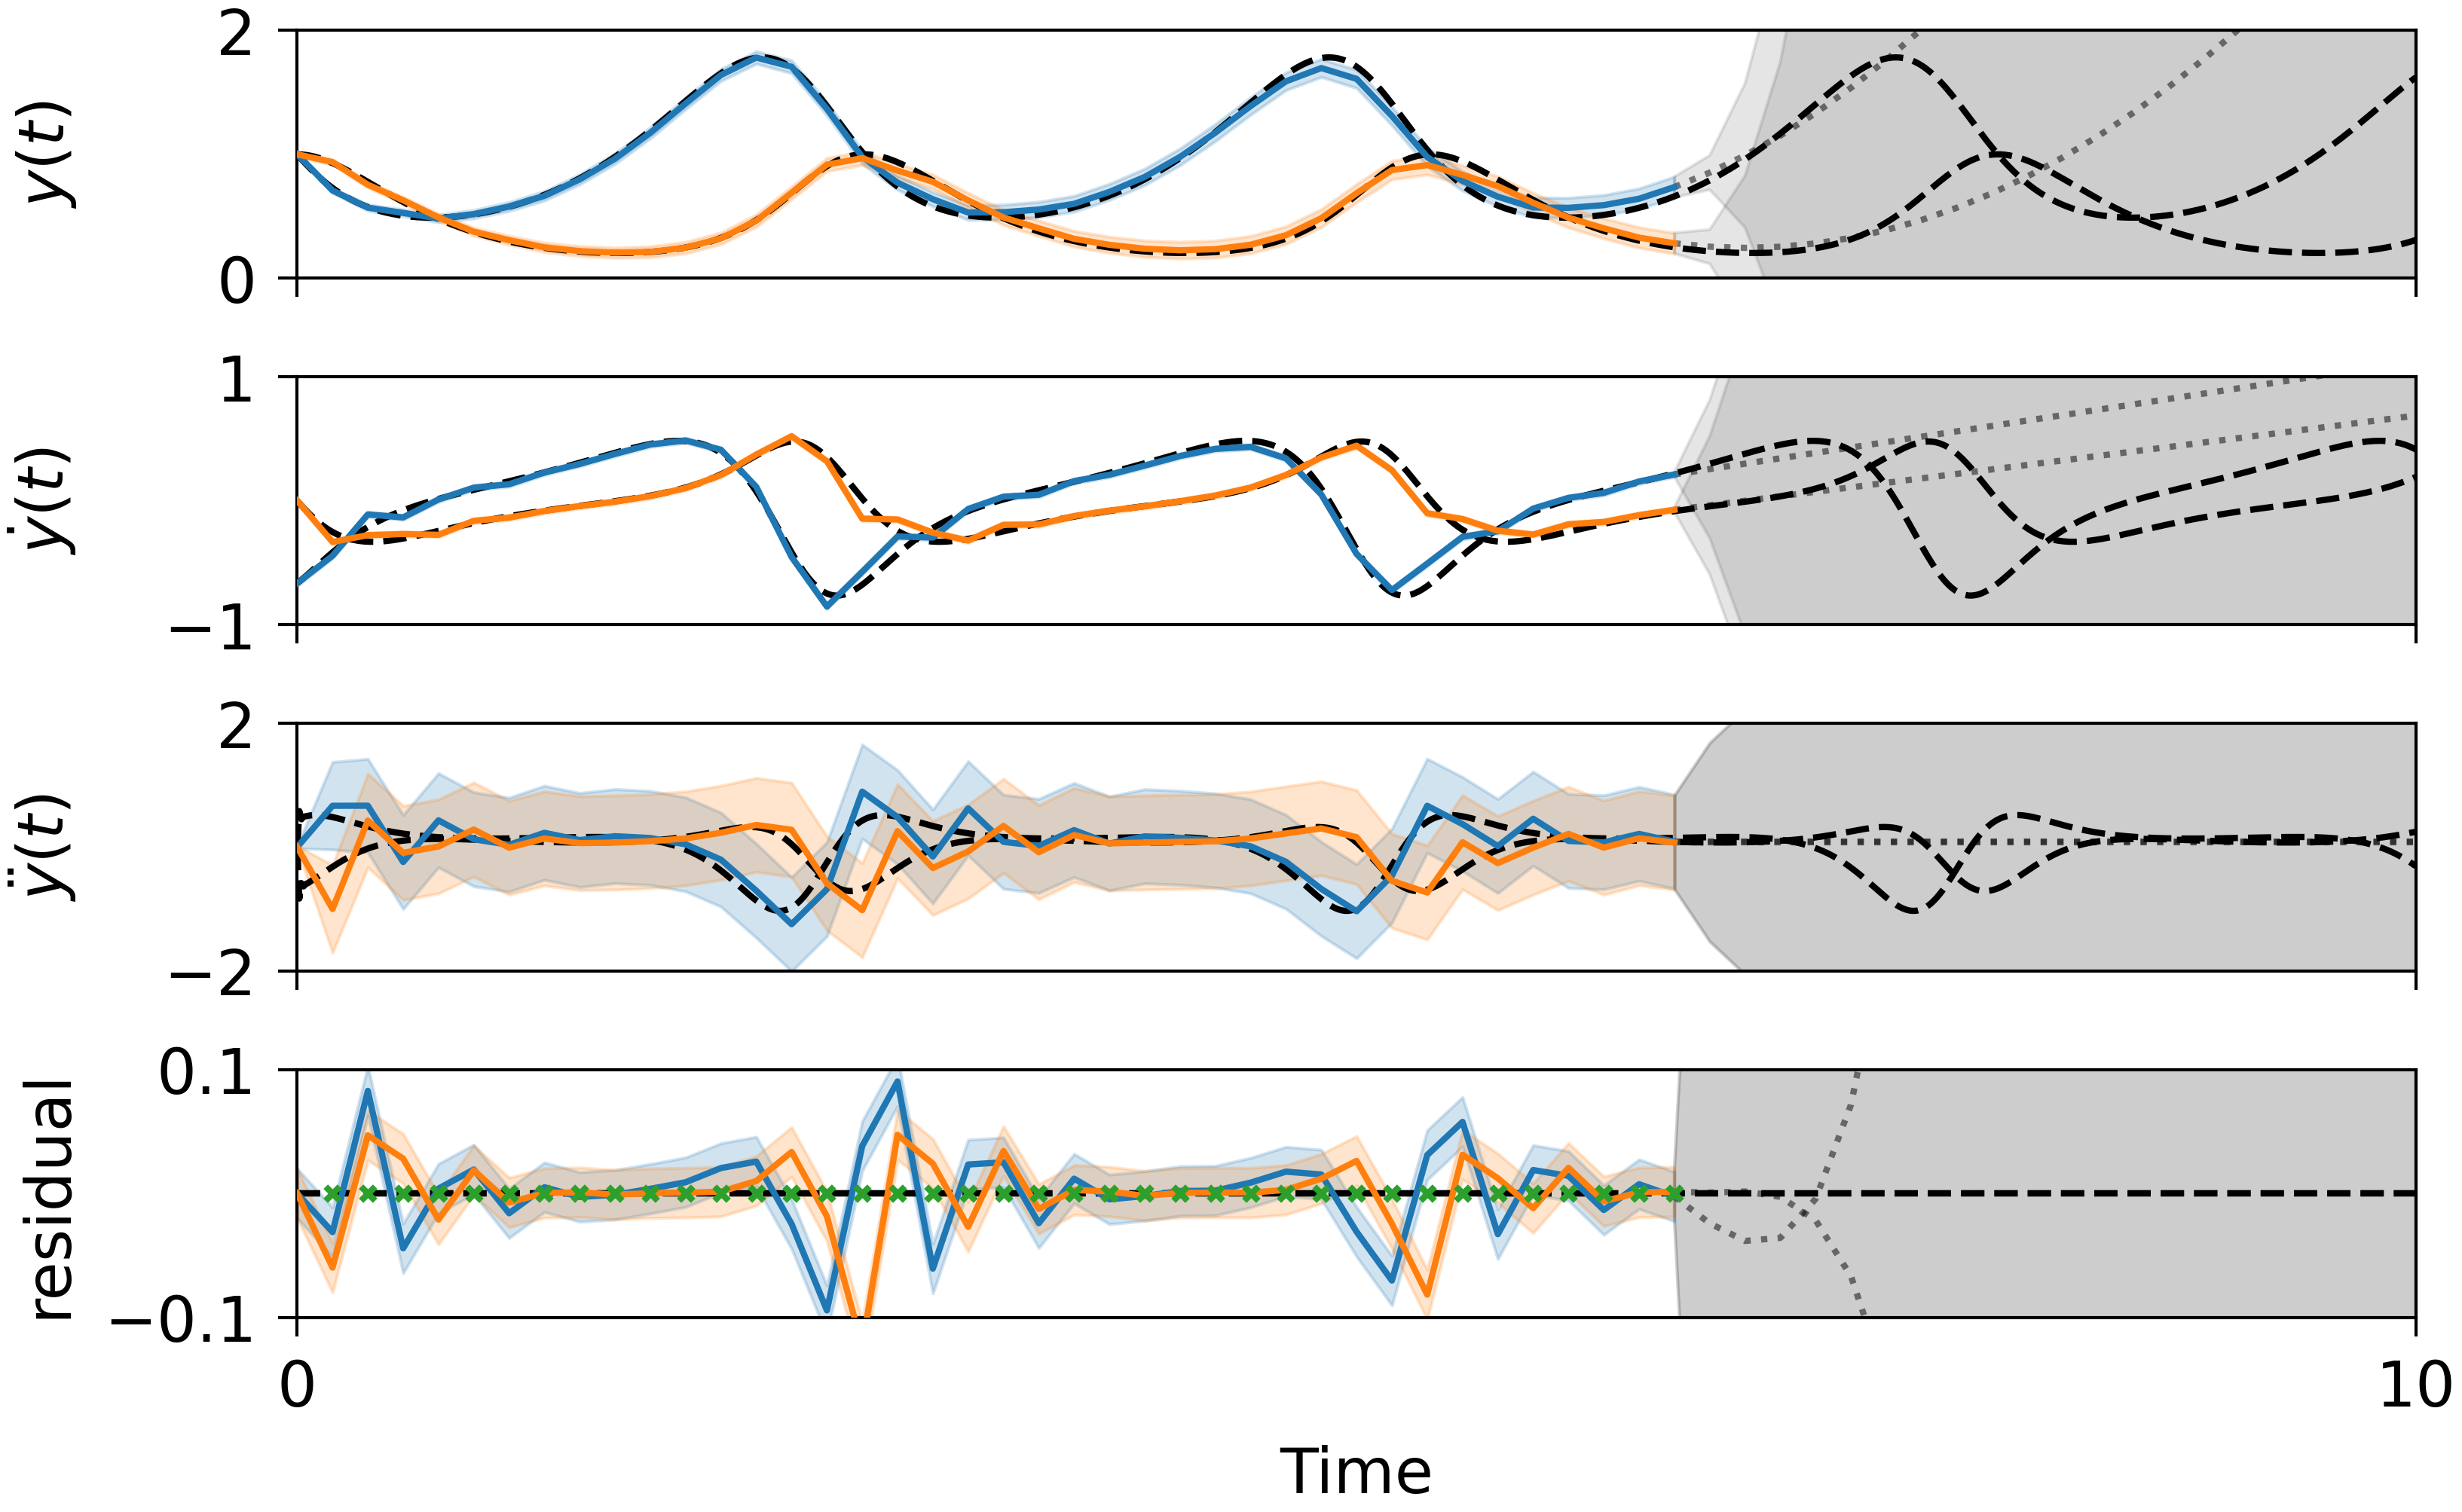

In [18]:
create_forward_plot(40)

In [19]:
for i in range(1,N+2):
    create_forward_plot(i, savefig=True)

### Iterative backward plotting

In [20]:
#m_sequence, P_sequence, m_predictions, P_predictions = compute_kalman_forward(mu_0, Sigma_0, A_h, b_h, Q_h, R_h, g, jacobian_g, z_sequence, N)

m_smoothed, P_smoothed = compute_kalman_backward(m_sequence, P_sequence, m_predictions, P_predictions, A_h, N)

m_smoothed = np.array(m_smoothed, dtype=float)
P_smoothed = np.array(P_smoothed, dtype=float)

zs_smoothed = []
zf_var_smoothed = []
for k in range(m_smoothed.shape[0]):
    zs_smoothed.append(g(m_smoothed[k,:]))
    Jk = jacobian_g(m_smoothed[k, :])
    zf_var_smoothed.append(Jk @ P_smoothed[k, :] @ Jk.T)
zf_var_smoothed = np.array(zf_var_smoothed, dtype=float)
zs_smoothed = np.array(zs_smoothed, dtype=float)

In [21]:
def create_backward_plot(k, savefig=False):

    fig, axs = plt.subplots(4, 1, sharex=True, layout='constrained')
    plot_ax_with_smooth(ts, m_sequence[:,0], P_sequence[:,0,0], t, m_exact[:,0], m_smoothed[:,0], P_smoothed[:,0,0], k, ax=axs[0], x_lim=[t0,t1], y_lim=[0,2], c1=colors[0], c2=colors[4])
    plot_ax_with_smooth(ts, m_sequence[:,1], P_sequence[:,1,1], t, m_exact[:,1], m_smoothed[:,1], P_smoothed[:,1,1], k, ax=axs[0], x_lim=[t0,t1], y_lim=[0,2], c1=colors[1], c2=colors[6])
    plot_ax_with_smooth(ts, m_sequence[:,2], P_sequence[:,2,2], t, m_exact[:,2], m_smoothed[:,2], P_smoothed[:,2,2], k, ax=axs[1], x_lim=[t0,t1], y_lim=[-1,1], c1=colors[0], c2=colors[4])
    plot_ax_with_smooth(ts, m_sequence[:,3], P_sequence[:,3,3], t, m_exact[:,3], m_smoothed[:,3], P_smoothed[:,3,3], k, ax=axs[1], x_lim=[t0,t1], y_lim=[-1,1], c1=colors[1], c2=colors[6])
    plot_ax_with_smooth(ts, m_sequence[:,4], P_sequence[:,4,4], t, m_exact[:,4], m_smoothed[:,4], P_smoothed[:,4,4], k, ax=axs[2], x_lim=[t0,t1], y_lim=[-2,2], c1=colors[0], c2=colors[4])
    plot_ax_with_smooth(ts, m_sequence[:,5], P_sequence[:,5,5], t, m_exact[:,5], m_smoothed[:,5], P_smoothed[:,5,5], k, ax=axs[2], x_lim=[t0,t1], y_lim=[-2,2], c1=colors[1], c2=colors[6])



    for i in range(3):
        # Styling to match other helper
        axs[i].set_xticks([ts[0], ts[-1]])
        axs[i].set_xticklabels([])
        axs[i].set_xlabel('')
        axs[i].grid(False)

    axs[0].set_ylabel(r'$y(t)$')
    axs[1].set_ylabel(r'$\dot{y}(t)$')
    axs[2].set_ylabel(r'$\ddot{y}(t)$')
    axs[3].set_ylabel('residual')

    plot_ax_with_smooth(ts, zs[:,0], zf_var[:,0,0], t, np.zeros_like(t), zs_smoothed[:,0], zf_var_smoothed[:,0,0], k, ax=axs[-1], x_lim=[t0,t1], y_lim=[-0.1,0.1], c1=colors[0], c2=colors[4])
    plot_ax_with_smooth(ts, zs[:,1], zf_var[:,1,1], t, np.zeros_like(t), zs_smoothed[:,1], zf_var_smoothed[:,1,1], k, x_lim=[t0,t1], y_lim=[-0.1,0.1], ax=axs[-1], c1=colors[1], c2=colors[6])
    axs[-1].scatter(ts[1:], z_sequence[:, 0], label="observed data", color=colors[2], zorder=10, marker='x', s=5)
    # remove axis legend; we'll add a figure-level legend
    # axs[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axs[-1].set_xlabel("Time")
    axs[-1].set_xticklabels([0,10])

    # Build a figure-level legend from all axes
    handles, labels = [], []
    for ax in axs:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    by_label = dict(zip(labels, handles))
    #fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.55, 1.2), ncol=3, frameon=True)
    fig.align_ylabels(axs)

    if savefig:
        plt.savefig(f"ODE_smoother_imgs/img_{k}.png", bbox_inches='tight')
        plt.close()
    else:
        plt.show()

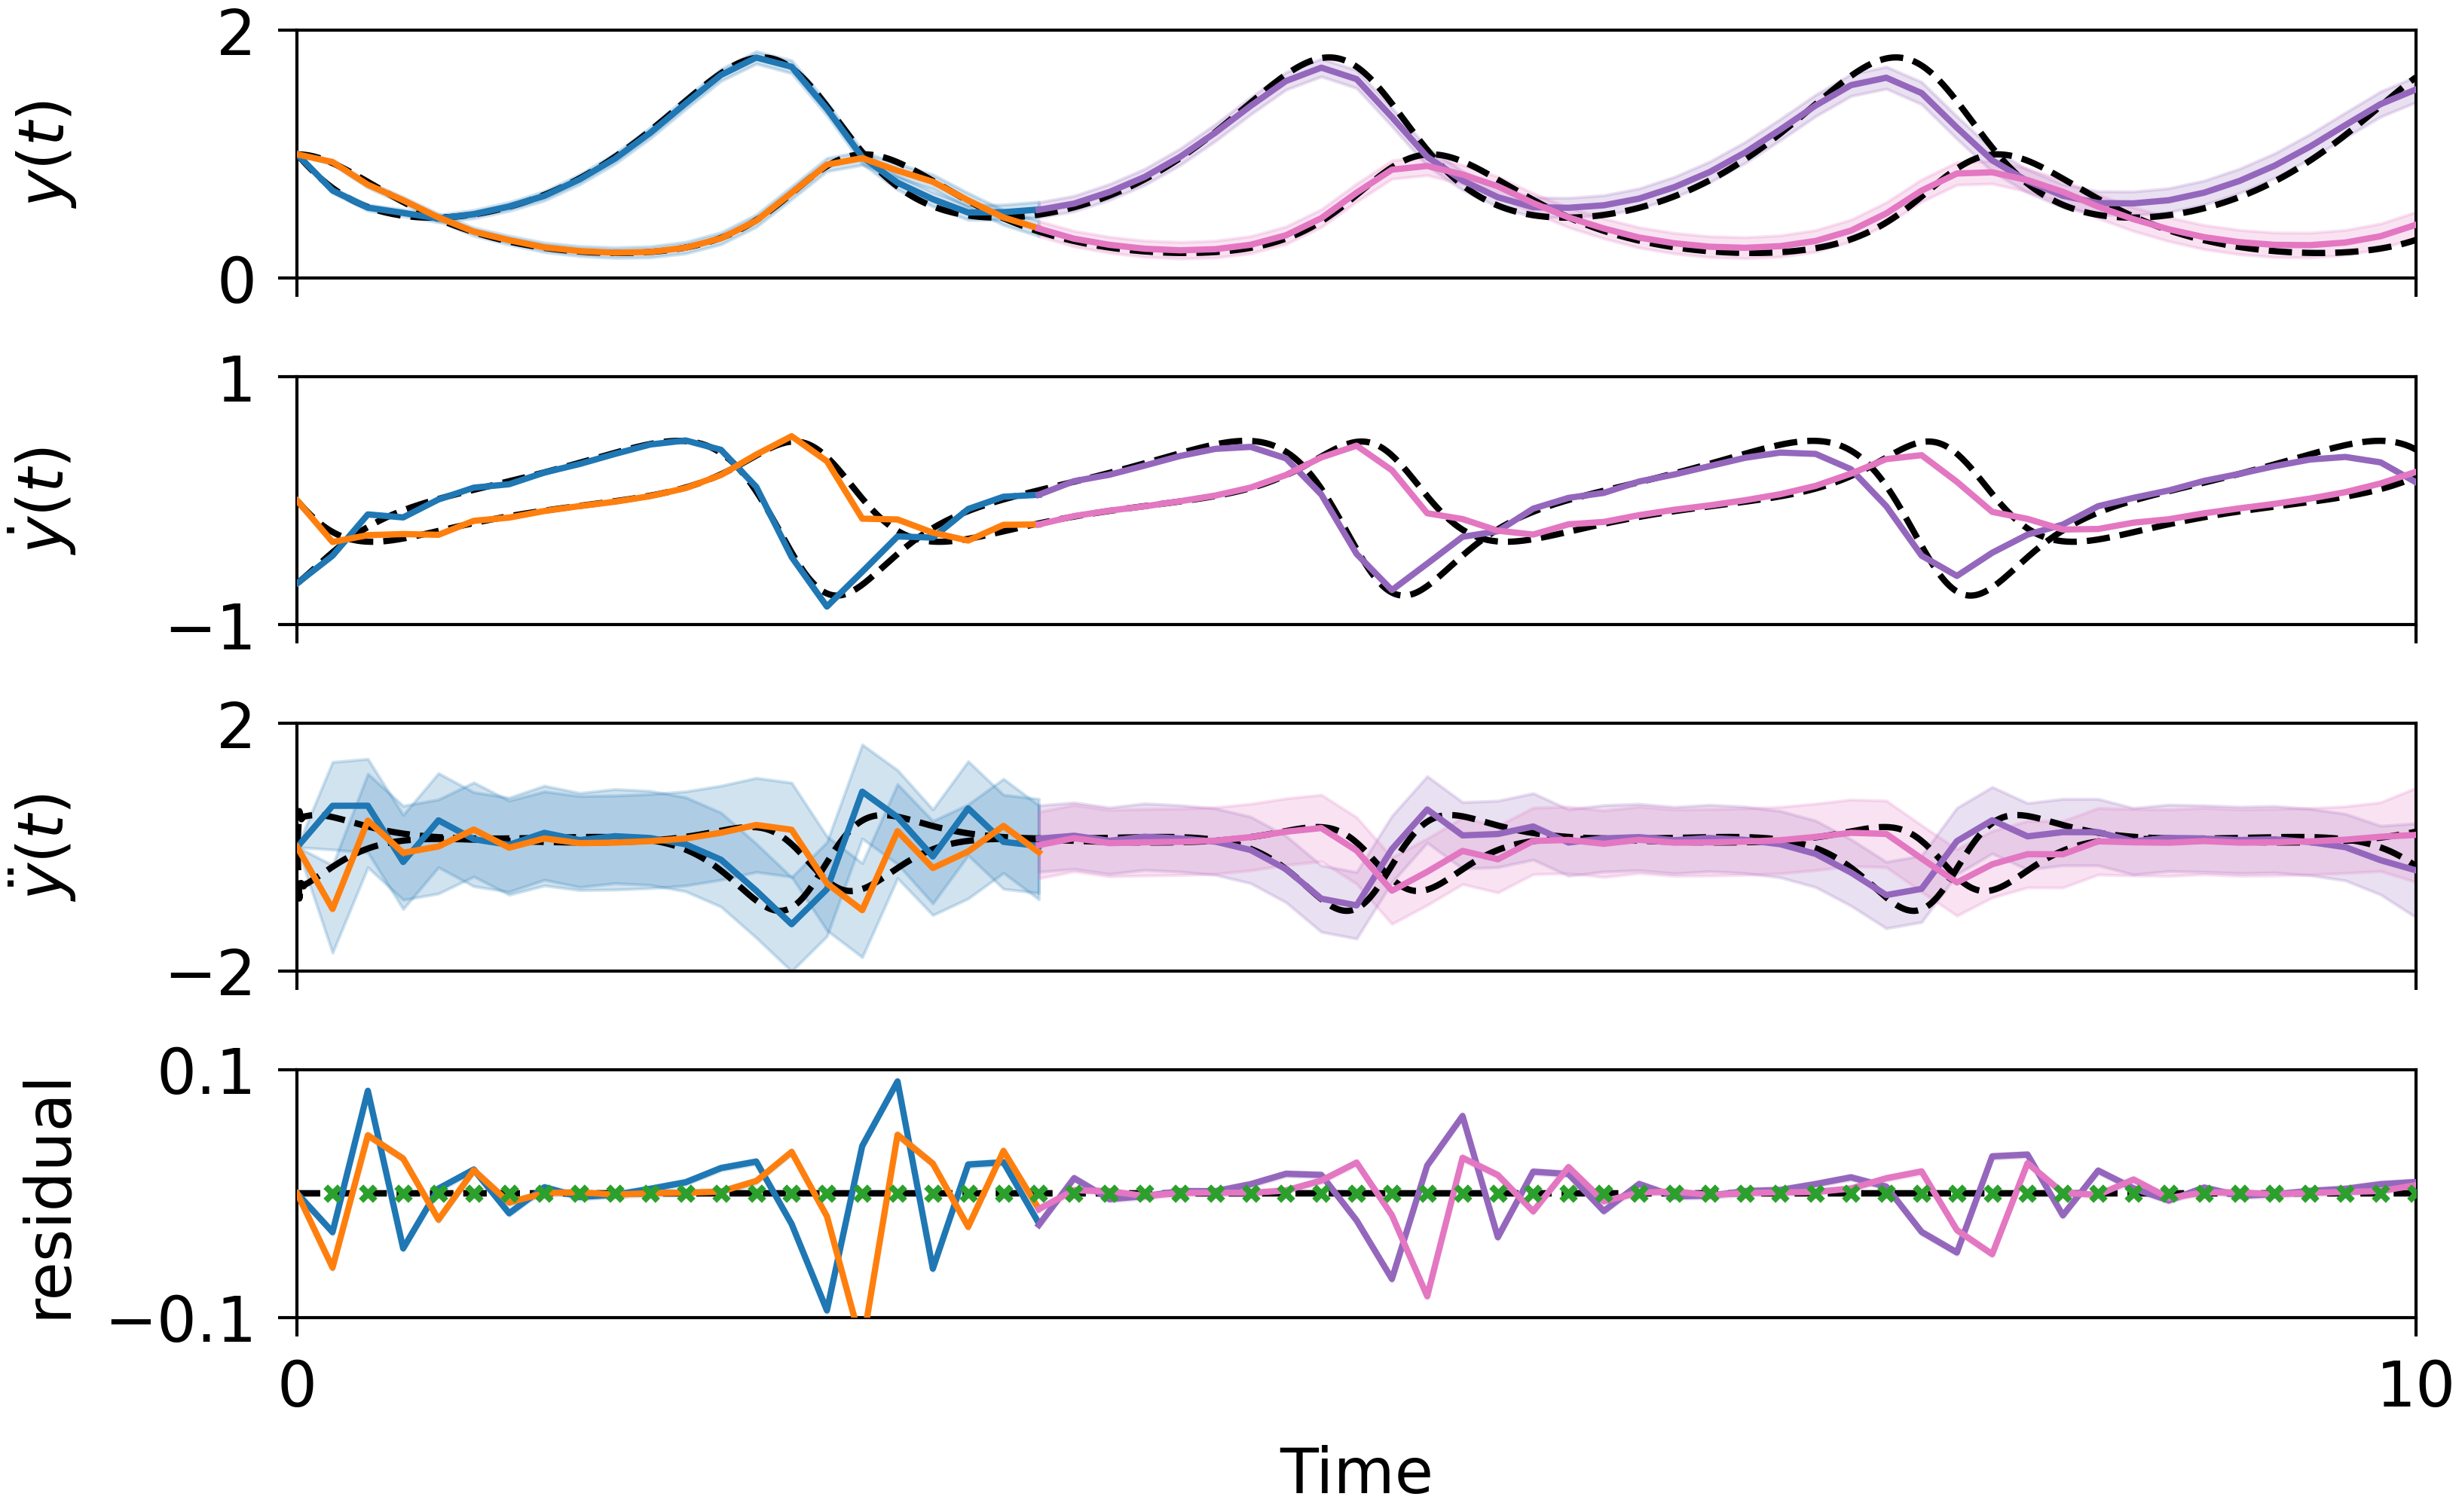

In [22]:
create_backward_plot(22)

In [23]:
for i in tqdm(range(1,N+2)):
    create_backward_plot(i, savefig=True)

100%|██████████| 61/61 [00:21<00:00,  2.88it/s]


### Sample paths from full posterior

In [24]:
Gs, ds, Lambdas = backward_transitions(m_sequence, P_sequence, m_predictions, P_predictions, A_h, N)
#sample backward transitions

In [25]:
X_s_samples = backward_sample_paths(100, m_sequence, P_sequence, Gs, ds, Lambdas, N)

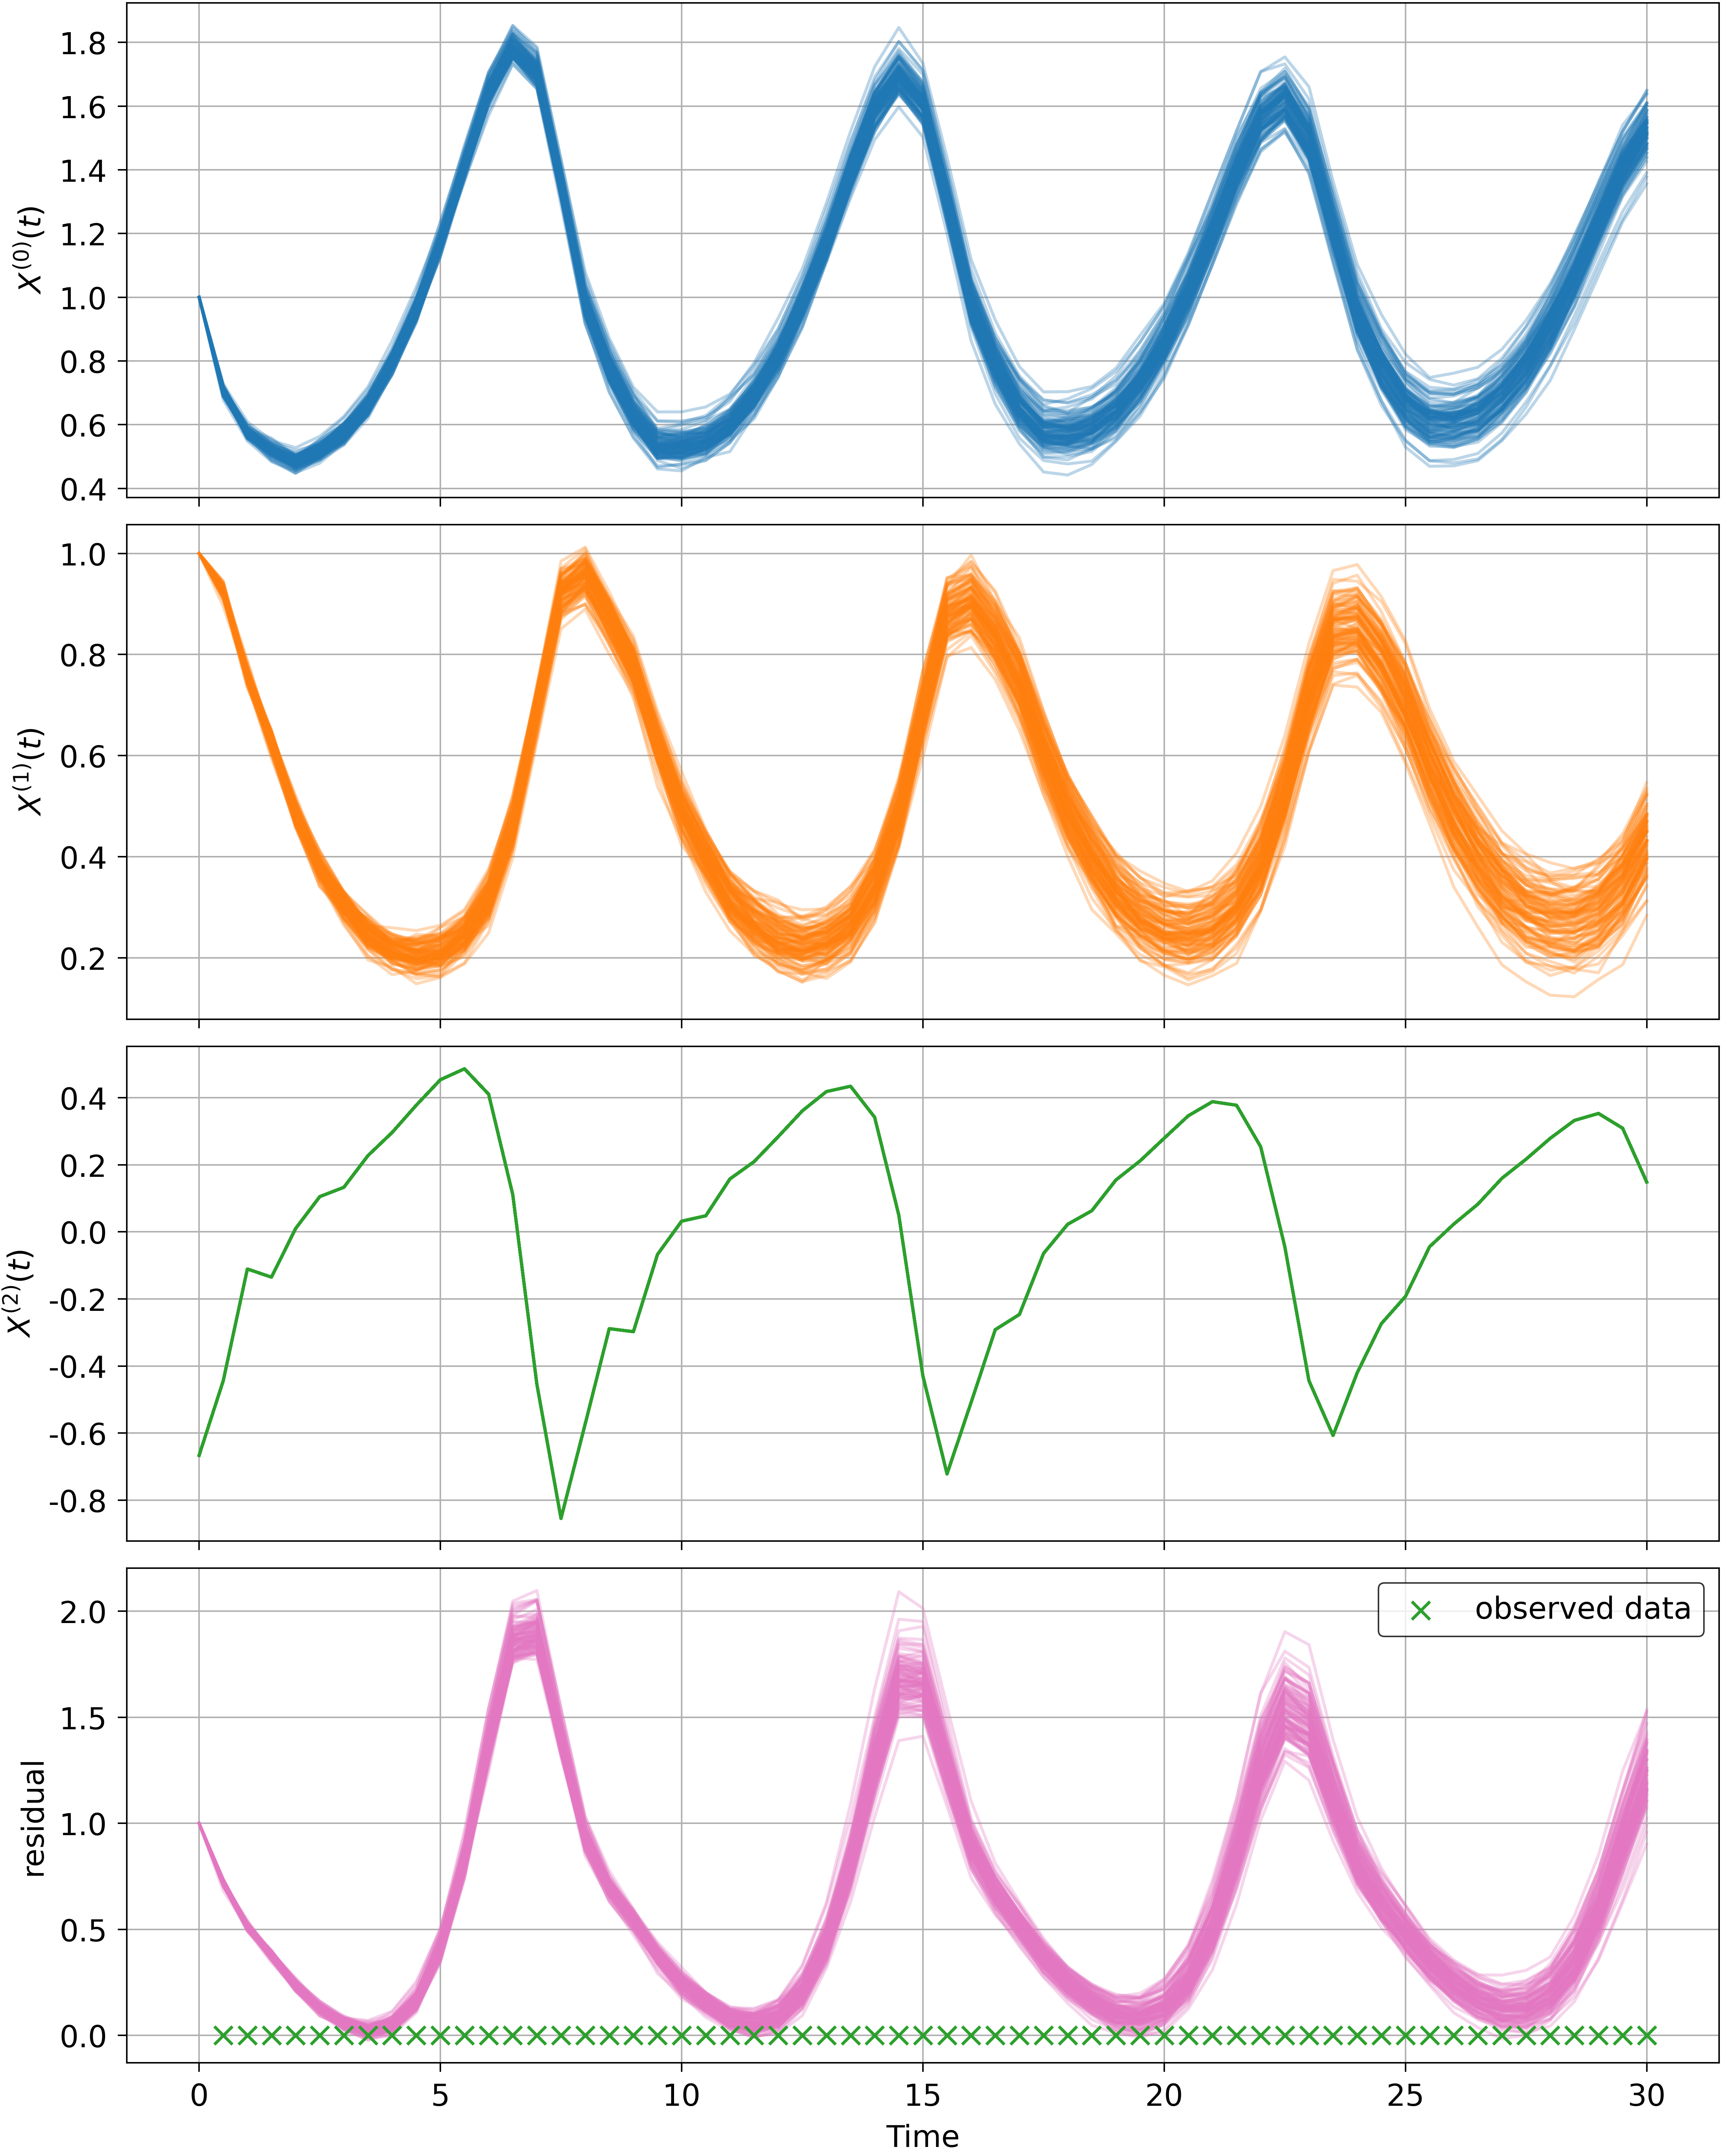

In [26]:
# Use the generalized sample path plotting function with error handling
component_labels = [f'$X^{{({i})}}(t)$' for i in range(3)]

def residual_func(sample):
    # For Lotka-Volterra system: compute residual g(X) = E_1 @ X - vf(E_0 @ X)
    try:
        return g(sample.T).T  # Transpose to match expected dimensions
    except:
        # Fallback: simple residual computation
        return sample[:, 1] - sample[:, 0] * (1 - sample[:, 0])

# Use the plotting utilities to handle dimension mismatches automatically
fig, axs = plot_sample_paths(
    ts, X_s_samples[:, :, :3], component_labels,
    residual_func=residual_func,
    observations=z_sequence if 'z_sequence' in locals() else None,
    colors=colors
)
